<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2

### <center> Автор материала: Андрей Шапиро 

# <center>Прогнозирование дневных температур в городе Челябинске</center>
### <center> Индивидуальный проект по анализу данных</center>

**План исследования**
 - Описание набора данных и признаков
 - Первичный анализ признаков
 - Первичный визуальный анализ признаков
 - Закономерности, "инсайты", особенности данных
 - Предобработка данных
 - Создание новых признаков и описание этого процесса
 - Кросс-валидация, подбор параметров
 - Построение кривых валидации и обучения 
 - Прогноз для тестовой или отложенной выборки
 - Оценка модели с описанием выбранной метрики
 - Выводы
 
 Более детальное описание [тут](https://goo.gl/cJbw7V).

In [214]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

###  Часть 1. Описание набора данных и признаков

In [197]:
df = pd.read_csv('chelpogoda.csv', sep=';',
                 dtype = {'datetime': str,
                           'temperature': np.int32,
                           'humidity': np.int32,
                           'pressure': np.int32,
                           'magnetic': str,
                           'wind': str
                })

In [198]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d, %H:%M', errors='coerce')

In [199]:
df.head()

,datetime,temperature,humidity,pressure,magnetic,wind
0,2008-06-18 15:00:00,28,39,740,Геомагнитное поле спокойное,Ветер 3 м/с
1,2008-06-19 09:00:00,19,63,741,Геомагнитное поле спокойное,Ветер юго-восточный 2 м/с
2,2008-06-19 15:00:00,30,27,741,Геомагнитное поле спокойное,Ветер южный 2-5 м/с
3,2008-06-20 09:00:00,21,50,740,Геомагнитное поле спокойное,Ветер южный - 1 м/с
4,2008-06-20 15:00:00,32,31,740,Геомагнитное поле спокойное,Ветер юго-западный 3-7 м/с


Данные о магнитном поле и ветре в текстовом виде и частично загрязнены ошибками ввода.

#### Магнитное поле

In [207]:
np.unique(df['magnetic'])[1:10]

array(['Геомагнитное поле : неустойчивое', 'Геомагнитное поле : спокойное',
       'Геомагнитное поле :спокойное', 'Геомагнитное поле ?????????',
       'Геомагнитное поле cпокойное', 'Геомагнитное поле Спокойное',
       'Геомагнитное поле возможно неустойчивое',
       'Геомагнитное поле возможно слабо возмущенное',
       'Геомагнитное поле возмущенное'], dtype=object)

Создадим из текстового описания магнитного поля три категориальных переменных, соответствующих спокойному, неустойчивому и возмущенному геомагнитное полю

In [201]:
df['magn_calm'] = df['magnetic'].str.match('.*[cс][по][рко].*').astype(int)
df['magn_unstable'] = df['magnetic'].str.match('.*не[уч]с?то.*').astype(int)
df['magn_disturbant'] = df['magnetic'].str.match('.*возмущ.*').astype(int)

#### Ветер

In [209]:
np.unique(df['wind'])[1:20]

array(['Ветер 2-6 м/с', 'Ветер 3 м/с', 'Ветер 80',
       'Ветер :Западный 2-6 м/с', 'Ветер :Западный 3-8 м/с',
       'Ветер ???????? 2-6 ?/?', 'Ветер cверный 2-5 м/с',
       'Ветер cеверный 1-3 м/с', 'Ветер cеверный 1-5 м/с',
       'Ветер cеверный 1-7 м/с', 'Ветер cеверный 2-11 м/с',
       'Ветер cеверный 2-5 м/с', 'Ветер cеверный 2-6 м/с',
       'Ветер cеверный 2-7 м/с', 'Ветер cеверный 2-8 м/с',
       'Ветер cеверный 3-10 м/с', 'Ветер cеверный 3-5 м/с',
       'Ветер cеверный 3-6 м/с', 'Ветер cеверный 3-7 м/с'], dtype=object)

Возьмём границы изменения силы ветра в качестве переменных

In [203]:
wind_minmax = df['wind'].str.extract('(\d+)-?(\d+)? ?.*', expand=False)
df['wind_min'] = wind_minmax.iloc[:, 0]
df['wind_max'] = wind_minmax.iloc[:, 1]

df['wind_max'] = list(map(lambda x: float(df.loc[x[0], 'wind_min']) if np.isnan(float(x[1])) else float(x[1]), enumerate(df['wind_max'].values)))
df['wind_min'] = df['wind_min'].astype(float)

###  Часть 2. Первичный анализ признаков

In [204]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
X = df[['datetime', 'humidity', 'pressure', 'magn_calm', 'magn_unstable', 'magn_disturbant']]
y = df[['temperature']]

X['wind_max'] = df['wind_max'].fillna(0).astype(int)

/Users/andrew/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [212]:
X.iloc[1:10,:]

,datetime,humidity,pressure,magn_calm,magn_unstable,magn_disturbant,wind_max
1,2008-06-19 09:00:00,63,741,1,0,0,2
2,2008-06-19 15:00:00,27,741,1,0,0,5
3,2008-06-20 09:00:00,50,740,1,0,0,1
4,2008-06-20 15:00:00,31,740,1,0,0,7
5,2008-06-21 09:00:00,72,740,1,0,0,3
6,2008-06-21 15:00:00,49,739,1,0,0,4
7,2008-06-22 09:00:00,64,740,1,0,0,3
8,2008-06-22 15:00:00,50,740,1,0,0,4
9,2008-06-23 09:00:00,61,740,1,0,0,2


###  Часть 3. Первичный визуальный анализ признаков

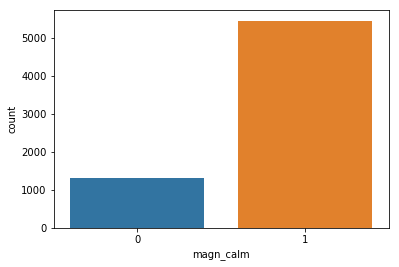

In [219]:
sns.countplot(X['magn_calm']);

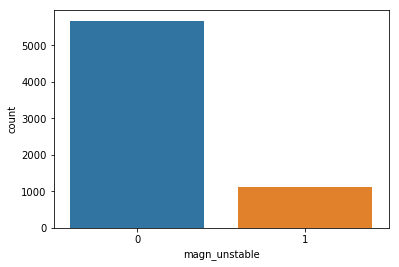

In [220]:
sns.countplot(X['magn_unstable']);

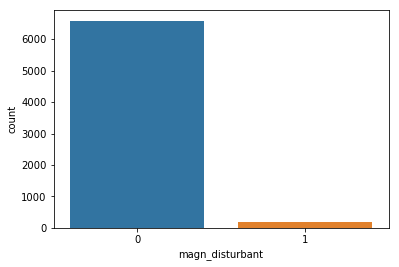

In [221]:
sns.countplot(X['magn_disturbant']);

###  Часть 4. Закономерности, "инсайты", особенности данных

###  Часть 5. Предобработка данных 

###  Часть 6. Создание новых признаков и описание этого процесса

###  Часть 7. Кросс-валидация, подбор параметров

###  Часть 8. Построение кривых валидации и обучения 

###  Часть 9. Прогноз для тестовой или отложенной выборки

###  Часть 10. Оценка модели с описанием выбранной метрики

### Часть 11. Выводы 